# ***Import the dataset***

In [17]:
import pandas as pd

# Load both yearly sheets into a single DataFrame
file_path = "online_retail_II.xlsx"
sheets = pd.ExcelFile(file_path).sheet_names
df_list = [pd.read_excel(file_path, sheet_name=s) for s in sheets]
df = pd.concat(df_list, ignore_index=True)

# **Look at the Data Set**

In [18]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [19]:

print("Shape:", df.shape)

Shape: (1067371, 8)


In [5]:
print("\nColumns:", df.columns.tolist())


Columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']


In [23]:
# --- Harmonise column names -----------------------------------------------
df.columns = df.columns.str.strip()            # remove any trailing spaces
if 'Price' in df.columns and 'UnitPrice' not in df.columns:
    df = df.rename(columns={'Price': 'UnitPrice'})


In [24]:
print("\nDescriptive statistics (Quantity & UnitPrice):\n",
      df[['Quantity', 'UnitPrice']].describe())



Descriptive statistics (Quantity & UnitPrice):
            Quantity     UnitPrice
count  1.067371e+06  1.067371e+06
mean   9.938898e+00  4.649388e+00
std    1.727058e+02  1.235531e+02
min   -8.099500e+04 -5.359436e+04
25%    1.000000e+00  1.250000e+00
50%    3.000000e+00  2.100000e+00
75%    1.000000e+01  4.150000e+00
max    8.099500e+04  3.897000e+04


In [25]:
df['Sales'] = df['Quantity'] * df['UnitPrice']


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns


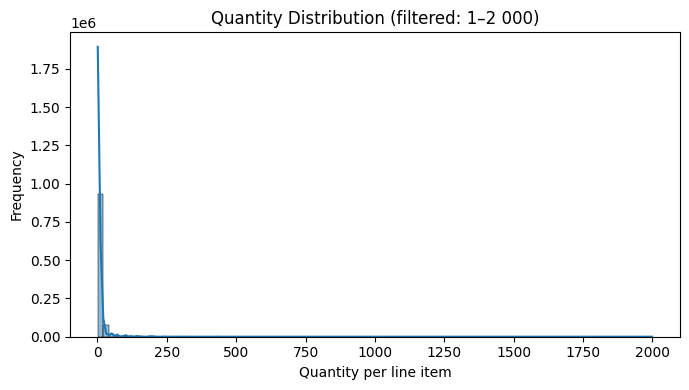

In [27]:
#  filter out cancellations & extreme outliers
df_clean = df[(~df['Invoice'].astype(str).str.startswith('C')) &   # drop cancels
              (df['Quantity'].between(1, 2000))]                  # keep reasonable range

#   plot with smaller bins or a log x-axis
plt.figure(figsize=(7,4))
sns.histplot(df_clean['Quantity'], bins=100, kde=True)
plt.title("Quantity Distribution (filtered: 1–2 000)")
plt.xlabel("Quantity per line item")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

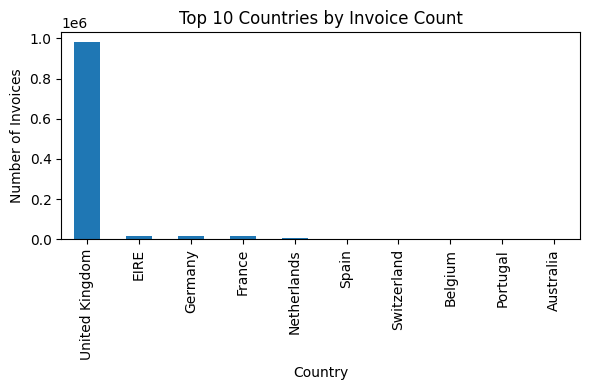

In [28]:
# Top 10 countries by transaction count
top_countries = df['Country'].value_counts().head(10)
plt.figure(figsize=(6,4))
top_countries.plot(kind='bar')
plt.title("Top 10 Countries by Invoice Count")
plt.xlabel("Country")
plt.ylabel("Number of Invoices")
plt.tight_layout()
plt.show()

In [29]:
df['UnitPrice'].describe(percentiles=[.99, .999])


,UnitPrice
count,1.067371e+06
mean,4.649388e+00
std,1.235531e+02
min,-5.359436e+04
50%,2.100000e+00
99%,1.800000e+01
99.9%,2.170160e+02
max,3.897000e+04


Negative prices removed : 6,207
> 99.9th-pct prices kept : 1,062  (plotted separately with log scale)
Main distribution count : 1,060,102


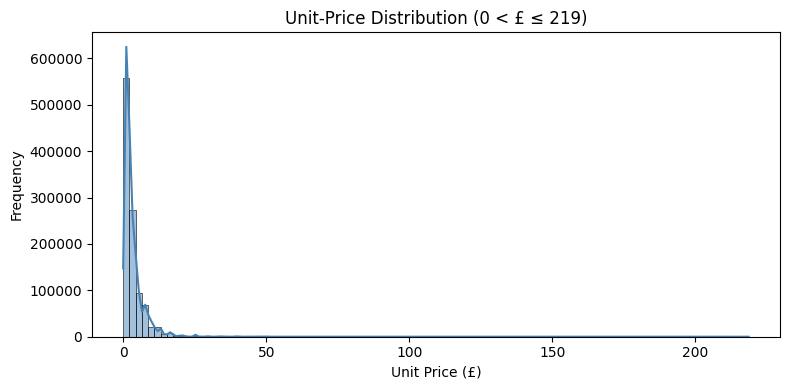

In [30]:

# ---FILTER BAD / EXTREME VALUES ----------------
# drop negatives
df_pos  = df[df['UnitPrice'] > 0].copy()

# cap at the 99.9th percentile (≈ £217)
upper   = df_pos['UnitPrice'].quantile(0.999)
df_main = df_pos[df_pos['UnitPrice'] <= upper]

print(f"Negative prices removed : {(df['UnitPrice']<=0).sum():,}")
print(f"> 99.9th-pct prices kept : {(df_pos['UnitPrice']>upper).sum():,}  (plotted separately with log scale)")
print(f"Main distribution count : {len(df_main):,}")

# ---   PLOT MAIN RANGE (0–{upper:,.0f}) ------------
plt.figure(figsize=(8,4))
sns.histplot(df_main['UnitPrice'],
             bins=100, kde=True, color='steelblue')
plt.title(f"Unit-Price Distribution (0 < £ ≤ {upper:,.0f})")
plt.xlabel("Unit Price (£)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()



# **Preprocessing**

In [31]:
# 3. handle prices
df           = df[df['UnitPrice'] > 0]                         # remove negative/zero
upper        = df['UnitPrice'].quantile(0.999)                 # cap extreme 0.1 %
df['UnitPrice'] = df['UnitPrice'].clip(upper=upper)


/tmp/ipython-input-31-3739618998.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['UnitPrice'] = df['UnitPrice'].clip(upper=upper)


In [32]:

# 4. fill missing IDs
df['Customer ID'] = df['Customer ID'].fillna('Guest')


In [33]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Customer ID,Country,Sales
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,14.85


In [34]:
# ---- basic cleaning ------------------------------------------------------
df['Invoice']    = df['Invoice'].astype(str).str.strip()
df['InvoiceDate']= pd.to_datetime(df['InvoiceDate'])
df['StockCode']  = df['StockCode'].astype(str).str.strip()

# drop cancellations & negatives
df = df[~df['Invoice'].str.startswith('C')]
df = df[df['Quantity'] > 0]

# fix price column name if needed
if 'Price' in df.columns and 'UnitPrice' not in df.columns:
    df = df.rename(columns={'Price':'UnitPrice'})

# remove zero/negative/abnormal prices
df = df[df['UnitPrice'] > 0]
upper = df['UnitPrice'].quantile(0.999)
df['UnitPrice'] = df['UnitPrice'].clip(upper=upper)

# fill missing customer
df['Customer ID'] = df['Customer ID'].fillna('Guest')

# add helpers
df['Sales']   = df['Quantity'] * df['UnitPrice']
df['Date']    = df['InvoiceDate'].dt.date
df['Month']   = df['InvoiceDate'].dt.month
df['Year']    = df['InvoiceDate'].dt.year
print(df.shape, "rows after cleaning")

(1041670, 12) rows after cleaning


In [39]:



import pandas as pd
import numpy as np
import holidays
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, itertools, datetime as dt, tensorflow as tf
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings("ignore")


# **Aggregate to daily SKU demand**

In [35]:
daily = (df.groupby(['Date','StockCode'])
           .agg(Quantity=('Quantity','sum'),
                Sales=('Sales','sum'))
           .reset_index())

# choose ONE example SKU to illustrate modelling
example_sku = daily['StockCode'].value_counts().idxmax()
sku_df      = daily[daily['StockCode']==example_sku].copy()

# re-index to continuous dates; missing days → 0 demand
rng         = pd.date_range(sku_df['Date'].min(), sku_df['Date'].max(), freq='D')
sku_df      = (sku_df.set_index('Date')
                      .reindex(rng)
                      .fillna(0)
                      .rename_axis('ds')
                      .reset_index()
                      .rename(columns={'Quantity':'y'}))

print(sku_df.head())


          ds StockCode      y    Sales
0 2009-12-01    85123A  261.0   702.42
1 2009-12-02    85123A  750.0  1953.99
2 2009-12-03    85123A  359.0   988.43
3 2009-12-04    85123A  179.0   489.65
4 2009-12-05    85123A   96.0   249.60


# Feature engineering for tree/LSTM models**

In [36]:
import holidays
def create_features(df, lags=[1,2,3,7,14,28]):
    out = df.copy()
    # calendar
    out['dayofweek'] = out['ds'].dt.dayofweek
    out['month']     = out['ds'].dt.month
    out['year']      = out['ds'].dt.year
    # UK holiday flag
    uk_holidays = holidays.UnitedKingdom()
    out['holiday'] = out['ds'].isin(uk_holidays).astype(int)
    # lag features
    for l in lags:
        out[f'lag_{l}'] = out['y'].shift(l)
    # rolling
    out['rolling_7']  = out['y'].rolling(7).mean()
    out['rolling_30'] = out['y'].rolling(30).mean()
    return out.dropna()

sku_feat = create_features(sku_df)


# **Train-test split**

In [37]:
train_size = int(len(sku_feat)*0.8)
train, test = sku_feat.iloc[:train_size], sku_feat.iloc[train_size:]
X_train, y_train = train.drop(['y','ds'], axis=1), train['y']
X_test,  y_test  = test.drop(['y','ds'], axis=1),  test['y']


In [ ]:
def evaluate_model(y_true, y_pred):
    """
    Calculates RMSE, MAE, and MSE for given true and predicted values.

    Args:
        y_true: The actual values.
        y_pred: The predicted values.

    Returns:
        A tuple containing RMSE, MAE, and MSE.
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae, mse

# **SARIMA**

In [40]:
# quick grid-search (tiny)
p=d=q=range(0,2)
pdq    = list(itertools.product(p, d, q))
best_mse, best_order = np.inf, None
for order in pdq:
    try:
        model = SARIMAX(train['y'], order=order, seasonal_order=(1,1,1,7)).fit(disp=False)
        mse   = mean_squared_error(test['y'], model.forecast(len(test)))
        if mse < best_mse:
            best_mse, best_order = mse, order
    except: pass

sarima = SARIMAX(train['y'], order=best_order, seasonal_order=(1,1,1,7)).fit(disp=False)
sar_pred = sarima.forecast(len(test))
print("SARIMA RMSE:", np.sqrt(mean_squared_error(test['y'], sar_pred)))


SARIMA RMSE: 128.48117289212166


In [ ]:
sarima_rmse, sarima_mae, sarima_mse = evaluate_model(test['y'], sar_pred)
print(f"SARIMA RMSE: {sarima_rmse:.4f}")
print(f"SARIMA MAE:  {sarima_mae:.4f}")
print(f"SARIMA MSE:  {sarima_mse:.4f}")

SARIMA RMSE: 128.4812
SARIMA MAE:  75.4683
SARIMA MSE:  16507.4118


# **Prophet**

In [41]:
prop = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
prop.fit(train[['ds','y']].rename(columns={'ds':'ds','y':'y'}))
future  = test[['ds']].rename(columns={'ds':'ds'})
prop_fc = prop.predict(future)['yhat'].values
print("Prophet RMSE:", np.sqrt(mean_squared_error(test['y'], prop_fc)))


DEBUG:cmdstanpy:input tempfile: /tmp/tmp__uz5oo9/6u2iodi2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp__uz5oo9/rbp371zv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66059', 'data', 'file=/tmp/tmp__uz5oo9/6u2iodi2.json', 'init=/tmp/tmp__uz5oo9/rbp371zv.json', 'output', 'file=/tmp/tmp__uz5oo9/prophet_modelq0wkfv7e/prophet_model-20250704050936.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:09:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:09:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet RMSE: 144.88263611741465


In [ ]:
prop_rmse, prop_mae, prop_mse = evaluate_model(test['y'], prop_fc)
print(f"Prophet RMSE: {prop_rmse:.4f}")
print(f"Prophet MAE:  {prop_mae:.4f}")
print(f"Prophet MSE:  {prop_mse:.4f}")

Prophet RMSE: 144.8826
Prophet MAE:  94.5631
Prophet MSE:  20990.9782


# **XGBoost**

In [44]:
# scale numeric features
scaler   = StandardScaler()
X_train_s= scaler.fit_transform(X_train.drop('StockCode', axis=1))
X_test_s = scaler.transform(X_test.drop('StockCode', axis=1))

xg_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05,
                            max_depth=6, subsample=0.8,
                            objective='reg:squarederror', random_state=42)
xg_model.fit(X_train_s, y_train,
             eval_set=[(X_test_s, y_test)],
             verbose=False)

xg_pred  = xg_model.predict(X_test_s)
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, xg_pred)))

XGBoost RMSE: 11.443460101652269


In [ ]:
xg_rmse, xg_mae, xg_mse = evaluate_model(y_test, xg_pred)
print(f"XGBoost RMSE: {xg_rmse:.4f}")
print(f"XGBoost MAE:  {xg_mae:.4f}")
print(f"XGBoost MSE:  {xg_mse:.4f}")

XGBoost RMSE: 11.4435
XGBoost MAE:  4.5849
XGBoost MSE:  130.9528


 # **LSTM**

In [46]:
# reshape to [samples, timesteps, features]
seq_len = 30   # last 30 days used to predict next day
def make_sequences(df, seq_len=30):
    x, y = [], []
    for i in range(seq_len, len(df)):
        x.append(df.iloc[i-seq_len:i][['y']].values)
        y.append(df.iloc[i]['y'])
    return np.array(x), np.array(y)

lstm_train, lstm_test = sku_df.iloc[:train_size+30], sku_df.iloc[train_size:]
X_lstm_tr, y_lstm_tr  = make_sequences(lstm_train, seq_len)
X_lstm_te, y_lstm_te  = make_sequences(pd.concat([lstm_train.iloc[-seq_len:], lstm_test]), seq_len)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_len,1)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])
model.compile(loss='mse', optimizer='adam')
model.fit(X_lstm_tr, y_lstm_tr, epochs=30, batch_size=32,
          validation_split=0.1, verbose=0)
lstm_pred = model.predict(X_lstm_te).flatten()
print("LSTM RMSE:", np.sqrt(mean_squared_error(y_lstm_te, lstm_pred)))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
LSTM RMSE: 152.05819879658296


In [ ]:
lstm_rmse, lstm_mae, lstm_mse = evaluate_model(y_lstm_te, lstm_pred)
print(f"LSTM RMSE: {lstm_rmse:.4f}")
print(f"LSTM MAE:  {lstm_mae:.4f}")
print(f"LSTM MSE:  {lstm_mse:.4f}")

LSTM RMSE: 152.0582
LSTM MAE:  76.2562
LSTM MSE:  23121.6958
